# Notebook 3 : interprétabilité du modèle
---

Nous nous intéressons dans ce notebook à rendre intelligible, c'est-à-dire compréhensible par un humain, le modèle Random Forest créé dans le cadre de ce projet.
Pour cela, nous allons utiliser plusieurs méthodes :
- la *Mean Decrease Impurity Importance* (MDI),
- la *Permutation Importance*,
- le *Tree Interpreter*.

Ces méthodes sont globales dans le sens où elles servent à expliquer des résultats à l'échelle du modèle (par opposition à l'échelle locale qui explique les résultats d'une prédiction en particulier), mais TreeInterpreter est également une méthode locale.

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from eli5.sklearn.permutation_importance import PermutationImportance
from treeinterpreter import treeinterpreter

import src.config.column_names as col
import src.config.base as base
from src.infrastructure.build_dataset import DataBuilderFactory, DataMerger
from src.domain.cleaning import MissingValueTreatment
from src.domain.build_features import feature_engineering_transformer
from interpretability_utilities import plot_features_importance 
from interpretability_utilities import plot_observation_contribution

ModuleNotFoundError: No module named 'src'

In [3]:
from warnings import simplefilter
from pandas.core.common import SettingWithCopyWarning

# Ignorer les warnings pour améliorer la lisibilité
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action="ignore", category=SettingWithCopyWarning)

# 1. Chargement des données

In [2]:
# Build datasets

client_builder = DataBuilderFactory(base.TRAIN_CLIENT_DATA_PATH, 
                                    base.config_client_data, 
                                    base.ALL_CLIENT_DATA_TRANSLATION)
client_data = client_builder.transform('client')

eco_builder = DataBuilderFactory(base.TRAIN_ECO_DATA_PATH, base.config_eco_data)
eco_data = eco_builder.transform('eco')

# Merging files to final dataset
X, y = DataMerger(client_data, eco_data, col.MERGER_FIELD).transform()
y = y.eq('Yes').astype(int)

NameError: name 'DataBuilderFactory' is not defined

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=base.SEED)

In [6]:
column_names = ['BALANCE', 'NB_CONTACT_CURRENT_CAMPAIGN', 'NB_CONTACT_LAST_CAMPAIGN', 'EDUCATION_PRIMARY', 'EDUCATION_SECONDARY', 
                'HAS_HOUSING_LOAN', 'HAS_PERSO_LOAN', 'HAS_DEFAULT', 'IS_RETIRED', 'WAS_LAST_CAMPAIGN_SUCCESS', 'IS_SINGLE',
               'SUP_25_YEARS_OLD', 'SUP_60_YEARS_OLD', 'AGE', 'MONTH_LAST_CONTACT_DATE', 'HAS_LOAN', 'NB_DAYS_LAST_CONTACT','EMPLOYMENT_VARIATION_RATE',
                'IDX_CONSUMER_PRICE', 'IDX_CONSUMER_CONFIDENCE']

# 2. Chargement du modèle 

In [9]:
# Chargement de la pipeline
pipeline = pickle.load(open(base.SAVED_MODEL_PATH, "rb"))

# Extraction du classifieur
clf = pipeline.best_estimator_.named_steps['rf_clf']

# Extraction des étapes de pre-processing (imputation et feature engineering)
transfo_pipeline = pipeline.best_estimator_[:2]

In [11]:
# Transformation des datasets d'entrainement et de test
X_train_transformed = transfo_pipeline.fit_transform(X_train, y_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=column_names, index= X_train.index)

X_test_transformed = transfo_pipeline.fit_transform(X_test, y_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=column_names, index= X_test.index)

In [12]:
print(f'Il y a {X_train_transformed.shape[1]} variables après le feature engineering.\n')
print('Les variables sont les suivantes :')
print(column_names)

Il y a 20 variables après le feature engineering.

Les variables sont les suivantes :
['BALANCE', 'NB_CONTACT_CURRENT_CAMPAIGN', 'NB_CONTACT_LAST_CAMPAIGN', 'EDUCATION??', 'EDUCATION_SECONDARY', 'HAS_HOUSING_LOAN', 'HAS_PERSO_LOAN', 'HAS_DEFAULT', 'IS_RETIRED', 'WAS_LAST_CAMPAIGN_SUCCESS', 'IS_SINGLE', 'SUP_25_YEARS_OLD', 'SUP_60_YEARS_OLD', 'AGE', 'LAST_CONTACT_DATE', 'HAS_LOAN', 'NB_DAYS_LAST_CONTACT', 'IDX_EMPLOYMENT_RATE', 'IDX_CONSUMER_PRICE', 'IDX_CONSUMER_CONFIDENCE']


# 3. Importance des variables

## a. MDI (Mean Decrease Impurity Importance)

La MDI (Mean Decrease Impurity Importance), ou *feature importance*, nous renseigne sur les variables ayant eu le plus de poids dans l'entrainement du modèle. Précisément, la MDI correspond à la diminution de l'impureté des noeuds de l'arbre. Ce critère est ensuite pondéré par le nombre d'arbres de la forêt aléatoire.

In [13]:
importances = clf.feature_importances_

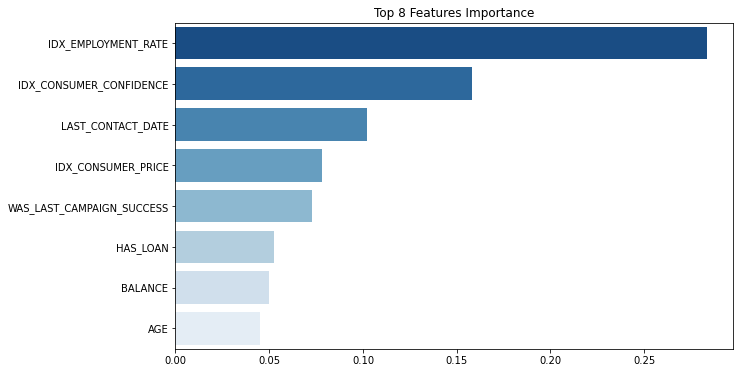

In [36]:
plot_features_importance(X_train_transformed,importances, 8)

La MDI nous montre que parmi les variables les plus importantes pour prédire si le client va souscrire au produit, les données socio-économiques ont une place très importante, en particulier le taux d'emploi et l'indice de confiance des consommateurs. La date de dernier contact avec le client pèse aussi significativement dans la balance.

## b. Permutation importance

La *permutation importance* (ou *Mean Decrease Accuracy Importance*) est une autre méthode utilisée pour déterminer les variables ayant eu le plus de poids dans la construction des arbres de décision de la forêt aléatoire.

Cette méthode calcule l'importance des variables en mesurant comment le score choisi (accuracy, recall,...) décroît quand cette variable n'est pas disponible. Cela montre donc à quel point la variable est précieuse, d'où son importance.

In [15]:
permutation_imp = PermutationImportance(clf, 
                                        scoring='average_precision', 
                                        n_iter=20, 
                                        random_state=42, 
                                        cv='prefit', 
                                        refit=False)

In [16]:
permutation_imp.fit(X_test_transformed, y_test)

PermutationImportance(estimator=RandomForestClassifier(class_weight={0: 1,
                                                                     1: 9},
                                                       max_depth=10,
                                                       min_samples_leaf=10,
                                                       n_estimators=220),
                      n_iter=20, random_state=42, refit=False,
                      scoring='average_precision')

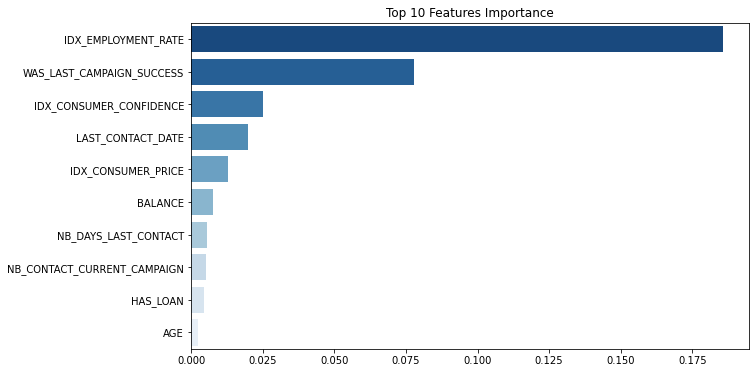

In [17]:
plot_features_importance(data=X_test_transformed, importances=permutation_imp.feature_importances_, n_feat=8)

Cette méthode montre également que les variables de type socio-économique ont un poids plus important que les autres variables.

On note ici que la variable WAS_LAST_CAMPAIGN_SUCCESS (indicatrice valant 1 si la campagne précédente avait été un succès) est importante par rapport aux autres.

# 4. Tree interpreter

La méthode de *Tree interpreter* fonctionne d'une autre manière : chaque prédiction (feuille de l'arbre, *leaf node*) est décomposée en fonction des contributions des variables (les noeuds) qui mènent à elle. Si une variable n'intervient pas dans le chemin vers la prédiction, cela signifie que cette variable n'a pas été utile, sa contribution est donc nulle. Les contributions sont donc calculées de manière locale (prédiction par prédiction).

Pour une forêt aléatoire, les contributions correspondent aux moyennes des contributions obtenues pour chacun des arbres.

Puis, pour obtenir l'importance de chaque variable à l'échelle globale du modèle, on fait la moyenne des contributions.  

In [18]:
predictions, bias, contributions = treeinterpreter.predict(clf, X_test_transformed)

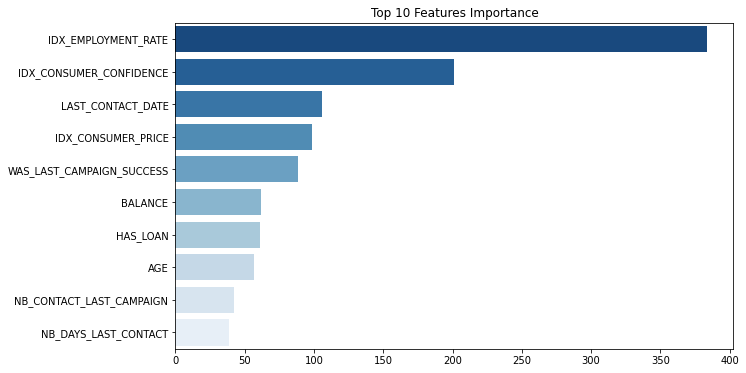

In [19]:
tree_interpreter_importances = contributions[:, :, 0].sum(axis=0)
plot_features_importance(data=X_test_transformed, importances=tree_interpreter_importances, n_feat=8)

Nous voyons ici aussi que les variables socio-économiques jouent un grand rôle dans la prédiction, et en particulier la variation du taux d'emploi qui arrive en 1ère position pour chaque méthode. C'est aussi le cas pour MONTH_LAST_CONTACT_DATE dont l'importance reste forte quelle que soit la méthode utilisée.